# **Titre :Analyse de données pour la prédiction et la prévention du désabonnement client dans la secteur des télecommunication.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **Data Loading and Churn Label Definition :**
### Loads telecom churn data into a PySpark DataFrame, creates a churn label, and displays its distribution.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# Initialize Spark session
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# Load data
df = spark.read.csv("/content/drive/MyDrive/Copy of telecom_churn_data (1).csv", header=True, inferSchema=True)

# Define churn label
df = df.withColumn(
    "churn",
    when((col("sep_vbc_3g") == 0) & (col("aug_vbc_3g") > 0), 1).otherwise(0)
)

# Check churn distribution
df.groupBy("churn").count().show()


+-----+-----+
|churn|count|
+-----+-----+
|    1|12353|
|    0|87646|
+-----+-----+



## **Handle Missing Data:**
### Drops columns with more than 50% missing values, retains valid columns, and fills missing values with column means.

In [2]:
# Drop  missing values
threshold = df.count() * 0.5
valid_cols = [col for col in df.columns if df.filter(df[col].isNotNull()).count() > threshold]
df = df.select(valid_cols)

# Fill missing values
from pyspark.sql.functions import mean

for column in df.columns:
    if df.select(column).dtypes[0][1] in ['double', 'int']:
        mean_value = df.select(mean(col(column))).collect()[0][0]
        df = df.fillna({column: mean_value})


## **Feature Engineering and Scaling**
### Creates aggregate features for total 3G usage and normalizes numerical columns using MinMaxScaler.

In [3]:
# Create aggregate feature for total 3G usage
from pyspark.sql.functions import sum as _sum

df = df.withColumn("total_vbc_3g",
                   col("jun_vbc_3g") + col("jul_vbc_3g") + col("aug_vbc_3g") + col("sep_vbc_3g"))

# Normalize numerical columns
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

numeric_cols = ["arpu_6", "arpu_7", "arpu_8", "arpu_9"]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

df = assembler.transform(df)
df = scaler.fit(df).transform(df)


## **Train-Test Split**
### Splits the data into training and testing sets .

In [4]:
# Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)


## **Random Forest Model Training and Evaluation**
### Trains a Random Forest model, makes predictions, and evaluates it using AUC.

In [5]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the model
rf = RandomForestClassifier(labelCol="churn", featuresCol="scaled_features")

# Train the model
rf_model = rf.fit(train_df)

# Make predictions
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="churn")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")


AUC: 0.645915857696425


## **Visualize Churn Distribution**
### Plots a histogram to visualize the churn distribution in the dataset.

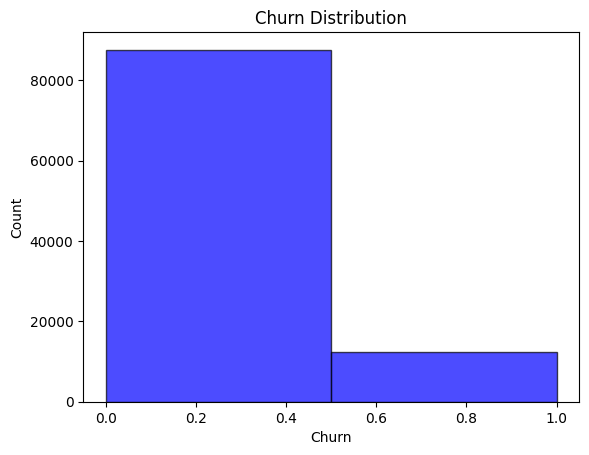

In [8]:
import matplotlib.pyplot as plt

# Convert churn data to Pandas
churn_data = df.select("churn").toPandas()

# Plot histogram
plt.hist(churn_data["churn"], bins=2, color='blue', alpha=0.7, edgecolor='black')
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()


##**Plot ROC Curve**
### Calculates and visualizes the ROC curve with AUC to assess model performance.

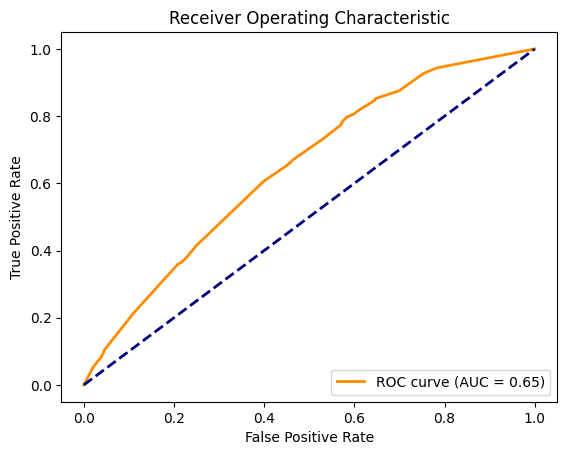

In [9]:
from sklearn.metrics import roc_curve, auc

# Extract probability and true labels
probabilities = predictions.select("probability", "churn").toPandas()
y_true = probabilities["churn"]
y_scores = probabilities["probability"].apply(lambda x: x[1])  # Probability of class 1

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


## **Feature Importance Extraction**
### Extracts and displays feature importance from the trained Random Forest model.

In [6]:
# Extract feature importances
importances = rf_model.featureImportances
print("Feature Importances:", importances)


Feature Importances: (4,[0,1,2,3],[0.027066621553097272,0.6639562114299421,0.26593559601496963,0.043041571001990915])


## **Predict Churn for New Data**
### Implements a function to predict churn for new data, including feature engineering and model loading.

In [12]:
import os
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Function to load the model and predict on new data
def predict_churn():
    # Initialize Spark session
    spark = SparkSession.builder.appName("ChurnPredictionNewData").getOrCreate()

    # Step 1: Get file path from the user
    file_path = input("Enter the file path for the new data (CSV format): ")

    # Step 2: Check if the file exists
    if not os.path.exists(file_path):
        print("Error: File not found. Please check the path and try again.")
        return

    # Step 3: Load new data
    print("Loading new data...")
    new_data = spark.read.csv(file_path, header=True, inferSchema=True)

    # Step 4: Process the new data (Feature Engineering and Scaling)
    print("Processing new data...")

    # Example: Add aggregate features (if used in training)
    new_data = new_data.withColumn("total_vbc_3g",
                                   col("jun_vbc_3g") + col("jul_vbc_3g") + col("aug_vbc_3g") + col("sep_vbc_3g"))

    # Assemble features (ensure columns match training features)
    numeric_cols = ["arpu_6", "arpu_7", "arpu_8", "arpu_9"]  # Update this based on training features
    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
    new_data = assembler.transform(new_data)

    # Scale features
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    scaler_model = scaler.fit(new_data)  # Fit scaler on new data
    new_data = scaler_model.transform(new_data)

    # Step 5: Load the trained model
    print("Loading the trained model...")
    model_path = "path/to/save/rf_model"  # Replace with your actual model path
    loaded_model = RandomForestClassificationModel.load(model_path)

    # Step 6: Predict churn for the new data
    print("Predicting churn...")
    predictions = loaded_model.transform(new_data)

    # Step 7: Display predictions
    print("Churn predictions (first 5 rows):")
    results = predictions.select("mobile_number", "probability", "prediction").toPandas()
    print(results.head())

    # Optional: Save predictions to a CSV file
    save_path = "churn_predictions.csv"
    results.to_csv(save_path, index=False)
    print(f"Predictions saved to {save_path}.")

    # Step 8: Explain the results
    print("\n### Explanation of Results ###")
    print("1. **mobile_number**: The unique identifier for the customer.")
    print("2. **probability**: The probability vector for each customer:")
    print("   - First value: Probability of not churning (staying).")
    print("   - Second value: Probability of churning (leaving).")
    print("3. **prediction**: The predicted class for the customer:")
    print("   - 0: Customer is likely to stay.")
    print("   - 1: Customer is likely to churn (leave).")
    print("\n### Next Steps ###")
    print("Based on these predictions:")
    print("   - Focus retention efforts on customers with a predicted churn (1).")
    print("   - Use the probability values to prioritize customers with high churn likelihood.")
    print("For example, if a customer has a churn probability > 0.7, consider offering special incentives to retain them.")


In [13]:
predict_churn()


Enter the file path for the new data (CSV format): /content/Book1.csv
Loading new data...
Processing new data...
Loading the trained model...
Predicting churn...
Churn predictions (first 5 rows):
   mobile_number                               probability  prediction
0     7000842753  [0.852627341557883, 0.14737265844211697]         0.0
Predictions saved to churn_predictions.csv.

### Explanation of Results ###
1. **mobile_number**: The unique identifier for the customer.
2. **probability**: The probability vector for each customer:
   - First value: Probability of not churning (staying).
   - Second value: Probability of churning (leaving).
3. **prediction**: The predicted class for the customer:
   - 0: Customer is likely to stay.
   - 1: Customer is likely to churn (leave).

### Next Steps ###
Based on these predictions:
   - Focus retention efforts on customers with a predicted churn (1).
   - Use the probability values to prioritize customers with high churn likelihood.
For example